In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os.path
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = "none"
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, normalize
from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

ModuleNotFoundError: No module named 'tqdm'

# Overview

This is a Jupyter notebook that is testing (for now) the [`stardist`](https://github.com/stardist/stardist) algorithm on 2D microscopy images to identify microtubules and MtQs in trypanosomes. Most of this notebook follows the [2D tutorials for stardist](https://github.com/stardist/stardist/tree/master/examples/2D), with some additional data cleaning and processing of our own.

## Code, data, organization

 * **Data**: All data used in this notebook is at `/gpfs/data/cbc/cdegraffenried/degraffenried_microtubules/data`. Laura annotates the images, then adds them to a Dropbox folder. August then `scps` them onto Oscar. Some folders get changed in between.
 * **Code**: is in the [`compbiocore/degraffenried_microtubules`](https://github.com/compbiocore/degraffenried_microtubules) repo - it is private, contact August to request access - as well as mirrored on Oscar at `/gpfs/data/cbc/cdegraffenried/degraffenried_microtubules`.

## stardist

stardist does object detection with star-convex shapes, of which microtubules are a form. More on the algorithm is described in these papers:

 * Uwe Schmidt, Martin Weigert, Coleman Broaddus, and Gene Myers. Cell Detection with Star-convex Polygons. International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI), Granada, Spain, September 2018.

 * Martin Weigert, Uwe Schmidt, Robert Haase, Ko Sugawara, and Gene Myers. Star-convex Polyhedra for 3D Object Detection and Segmentation in Microscopy. The IEEE Winter Conference on Applications of Computer Vision (WACV), Snowmass Village, Colorado, March 2020

# Data Processing and Overview

We need to do a few things:
 * process the annotated data and label the annotations with positive integer values while having the rest of the image be 0s
 * cut the images so that they are the same size
 
In the Dropbox folder, there are a few different folders:
 * **Annotated TIFFs:** These are the original annotated TIFFs. They do not have a corresponding unannotated TIFF.
 * **New files:**
   * **With MtQ:** This has the folders Annotated and Unannotated. Within Annotated there are TIFFs, PNGs, and also NEW TIFFs. The NEW TIFFs folder is due to the fact that some of the Annotated images (the first 34) had a circle around a dot as the annotation instead of a dot, which makes the label object non star-convex. In runs with those images the accuracy of ground truth reconstruction even with 128 rays did not exceed 0.65, when it should exceed 0.8 for the algorithm to work well.
   * **Without MtQ:** This has the folders Annotated and Unannotated. I have not inspected the images yet.
   
## Peculiarities with files
 * In the NEW TIFFs folder, for some reason the annotation images are a different size from the unannotated images. This means those have to be cut down to the same size.
 * In the `With MtQ/Annotated/TIFFs` folder, for some reason there is no `zap005.tiff` or `zap033.tiff`, but it is there in the `Unannotated/TIFFs` folder.
   
I will write a function to cut the images down to the same size later, but for now I will just use the existing images that are already the same size (i.e. 35-70 in `New files/With MtQ/Annotated/TIFFs`). We need to make sure all of the file names are the same though... Can do an `assert` with `os.path.basename` for that.

In [2]:
Y = sorted(glob('/gpfs/data/cbc/cdegraffenried/degraffenried_microtubules/data/test/annotated/*.tiff'))[32:70]
#print(list(map(os.path.basename, Y)))
#print("length of Y: ", len(Y))

X = sorted(glob('/gpfs/data/cbc/cdegraffenried/degraffenried_microtubules/data/test/unannotated/*.tiff'))[34:71]
#print(list(map(os.path.basename, X)))
#print("length of X: ", len(X))

assert(len(X)==len(Y))
assert(list(map(os.path.basename,Y))==list(map(os.path.basename,X)))

Y = list(map(imread,Y))
X = list(map(imread,X))

## Process images

### Creating masks from color values

So, 0th dimension is basically a row (or pixel in height). So when we do `test_Y[1][0]` we get back an 879x4 dimensional array which is the RGBA values (I'm assuming) for every pixel in row 0 or the first line of the image. 1st dimension is a column (or pixel in width). So when we do `test_Y[1][:,0]` we get back a 741x4 dimensional array which is RGBA values for every pixel in column 0 or the leftmost column line of the image. And finally 2nd dimension is the 4 RGBA values, so when we do `test_Y[1][:,:,0]` we get back a 741x879 array which is the R value for all of them.

The annotations are as follows: blue for microtubules, which corresponds to (0,0,255); green for MtQ 1, which corresponds to (0,255,0); yellow for MtQ 2 (255,255,0); pink for MtQ3 (255,0,255); cyan for MtQ4 (0,255,255). With that, we can redo the mask.

### Drop alpha channel

There is an alpha channel in all images, but the value is always 255. We should thus drop this channel as it will be one less thing that the model needs to train on.

In [2]:
plt.imshow(Y[0]);

NameError: name 'plt' is not defined

In [4]:
Y_new = [np.select([(img[:,:,0]<55) & (img[:,:,1]<55) & (img[:,:,2]>200), # blue for microtubules
                    (img[:,:,0]<55) & (img[:,:,1]>200) & (img[:,:,2]<55), # green for MtQ region
                    (img[:,:,0]>200) & (img[:,:,1]>200) & (img[:,:,2]<55), # yellow for MtQ region
                    (img[:,:,0]>200) & (img[:,:,1]<55) & (img[:,:,2]>200), # pink for MtQ region
                    (img[:,:,0]<55) & (img[:,:,1]>200) & (img[:,:,2]>200) # cyan for MtQ region
               ], [1,2,3,4,5], 0) for img in Y]

This block of code is testing to find the range we need to identify the colors as labels correctly

In [ ]:
img=Y[0]
#print("blue: ", np.where((img[:,:,0]==0) & (img[:,:,1]==0) & (img[:,:,2]>=232)))
"""
print("green -3:", np.where((img[:,:,0]<55) & (img[:,:,1]>200) & (img[:,:,2]<55)))
print("green -2:", np.where((img[:,:,0]<50) & (img[:,:,1]>205) & (img[:,:,2]<50)))
print("green -1:", np.where((img[:,:,0]<45) & (img[:,:,1]>210) & (img[:,:,2]<45)))
print("green 0:", np.where((img[:,:,0]<40) & (img[:,:,1]>215) & (img[:,:,2]<40)))
print("green 1:", np.where((img[:,:,0]<35) & (img[:,:,1]>220) & (img[:,:,2]<35)))
print("green 2:", np.where((img[:,:,0]<30) & (img[:,:,1]>225) & (img[:,:,2]<30)))

print("yellow:", np.where((img[:,:,0]>225) & (img[:,:,1]>225) & (img[:,:,2]<30)))
print("pink: ", np.where((img[:,:,0]>230) & (img[:,:,1]<25) & (img[:,:,2]>230)))
print("cyan:", np.where((img[:,:,0]<25) & (img[:,:,1]>230) & (img[:,:,2]>230)))
"""

In [5]:
img, lbl = X[0], fill_label_holes(Y_new[0])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3] # this is copied from stardist jupyter notebook but don't know what it means
# assumed axes ordering of img and lbl is: YX(C)

In [1]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('Labels')
None;

NameError: name 'plt' is not defined

In [7]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y_new]
    mean_iou = matching_dataset(Y_new, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


## Accuracy of ground truth reconstruction

This plot should tell us if we will get good results. It's doing much better with the newest images and them being in the correct order with X and Y matched up, but it does seem to max out at 0.8 which is interesting. However it does start much higher, it seems we only need 16 rays here.

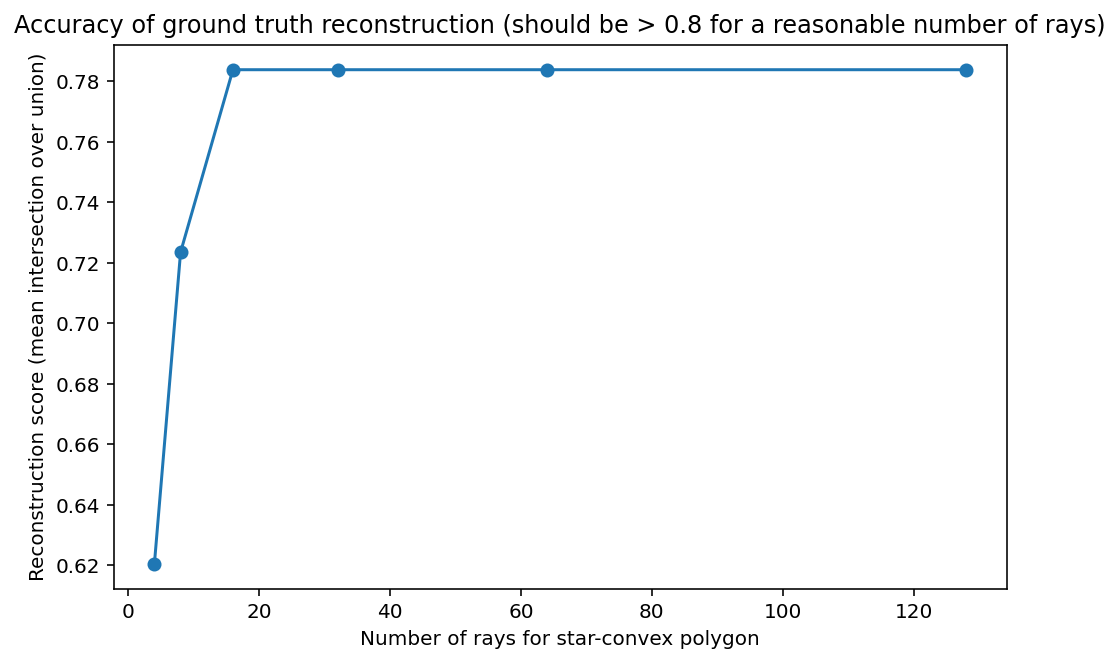

In [8]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

In [15]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

#X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y_new)]

Normalizing image channels independently.


100%|██████████| 37/37 [00:00<00:00, 53.97it/s]


In [16]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  37
- training:        31
- validation:       6


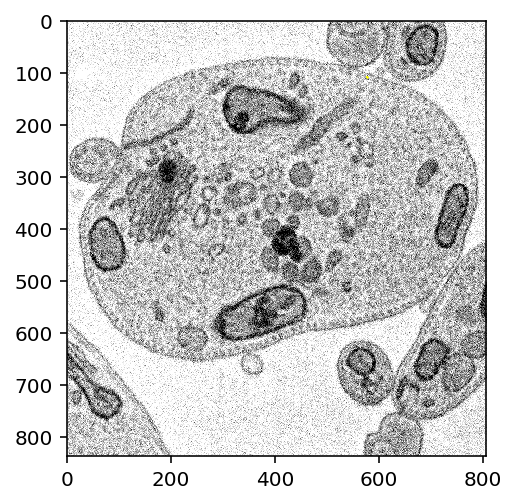

In [22]:
plt.imshow(X[0])

In [49]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap="gray")
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

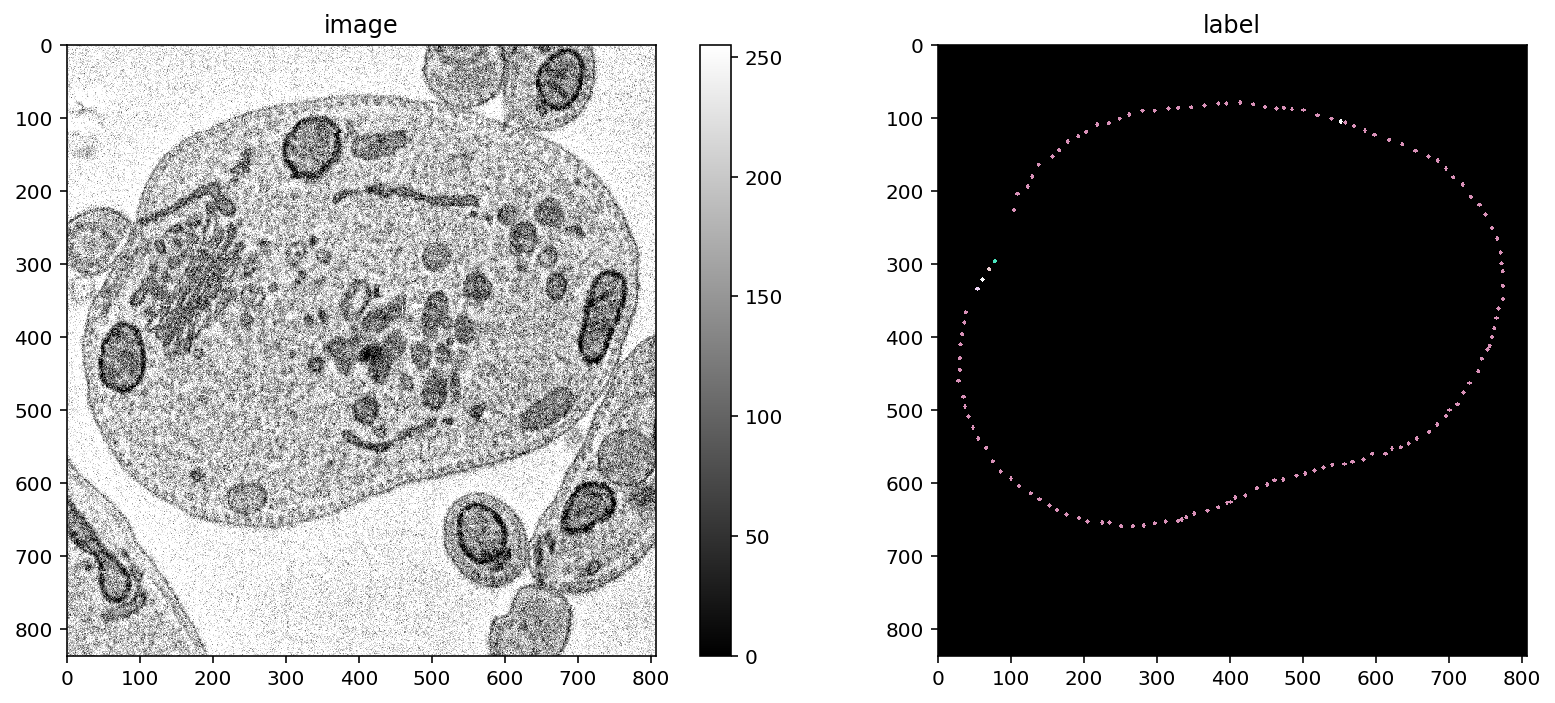

In [50]:
i = min(2, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [19]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=4, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 4), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 4,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 4),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [20]:
model = StarDist2D(conf, name='stardist', basedir='models')

base_model.py (149): output path for model already exists, files may be overwritten: /gpfs/scratch/aguang/stardist-test/models/stardist


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.125394, nms_thresh=0.3.


2023-03-16 13:06:44.194128: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:06:44.767697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22816 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:64:00.0, compute capability: 7.5


In [21]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2023-03-16 13:06:50.755014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


median object size:      [6. 6.]
network field of view :  [94 93]


# Data Augmentation

We augment the data with more images by randomly rotationg and flipping and changing intensity.

In [27]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    #x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


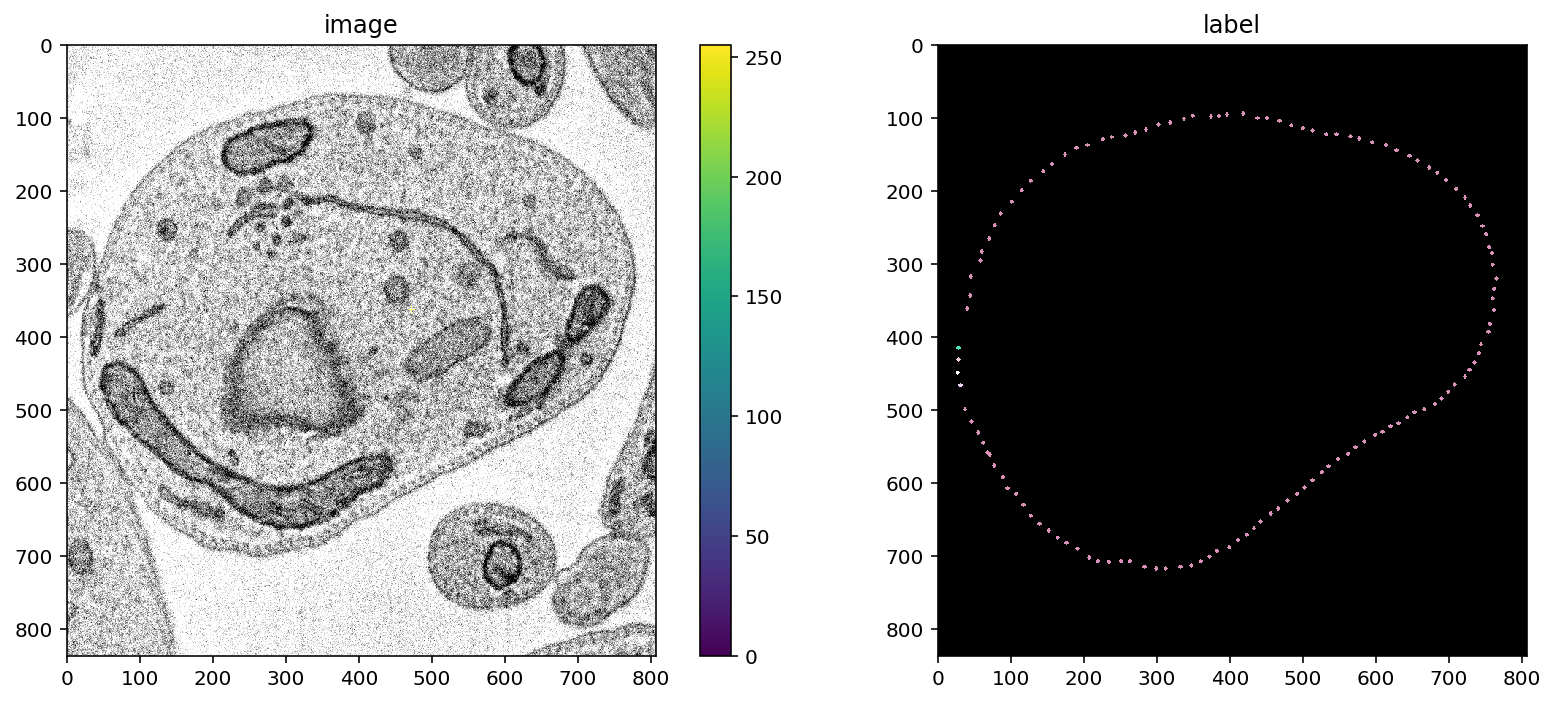

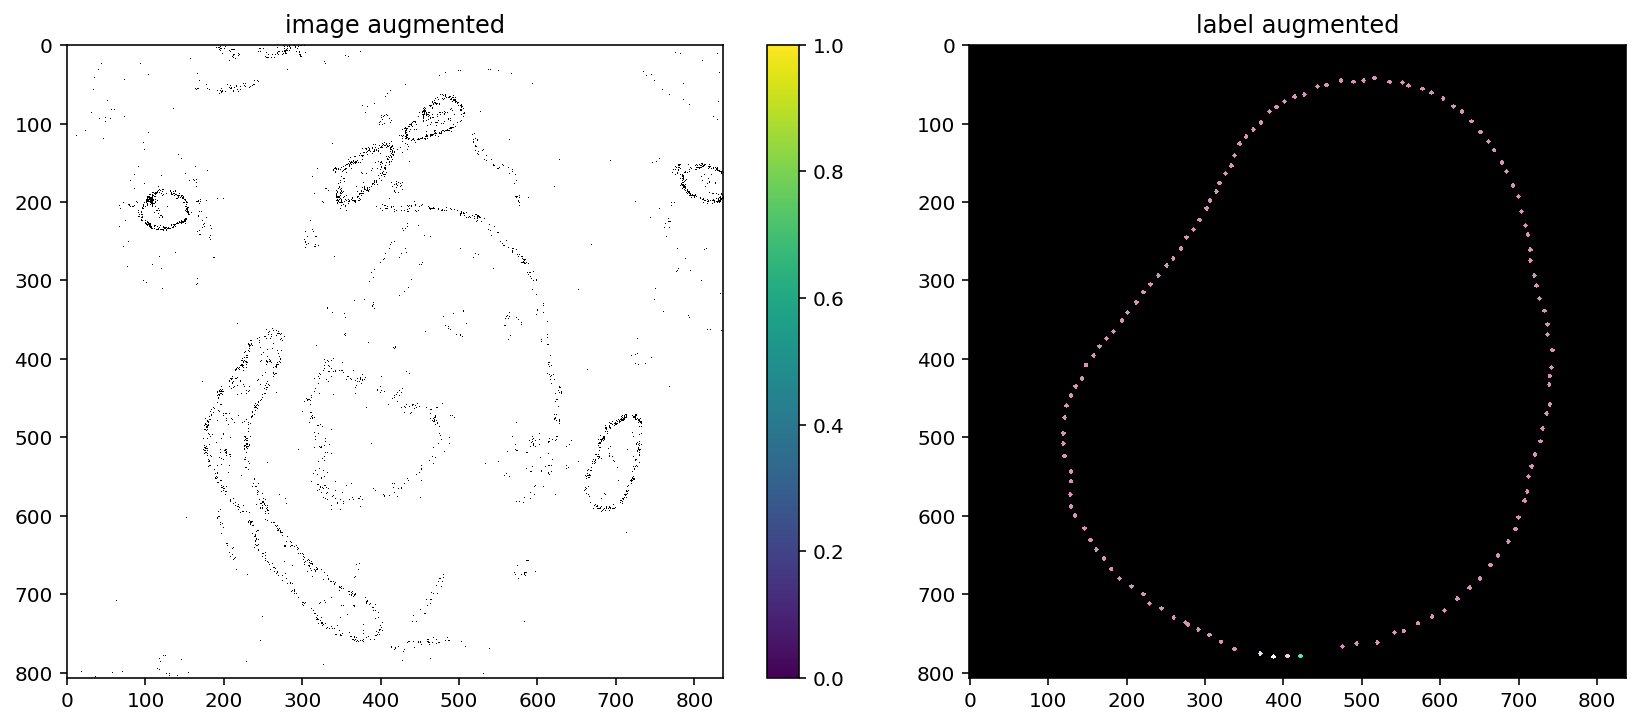

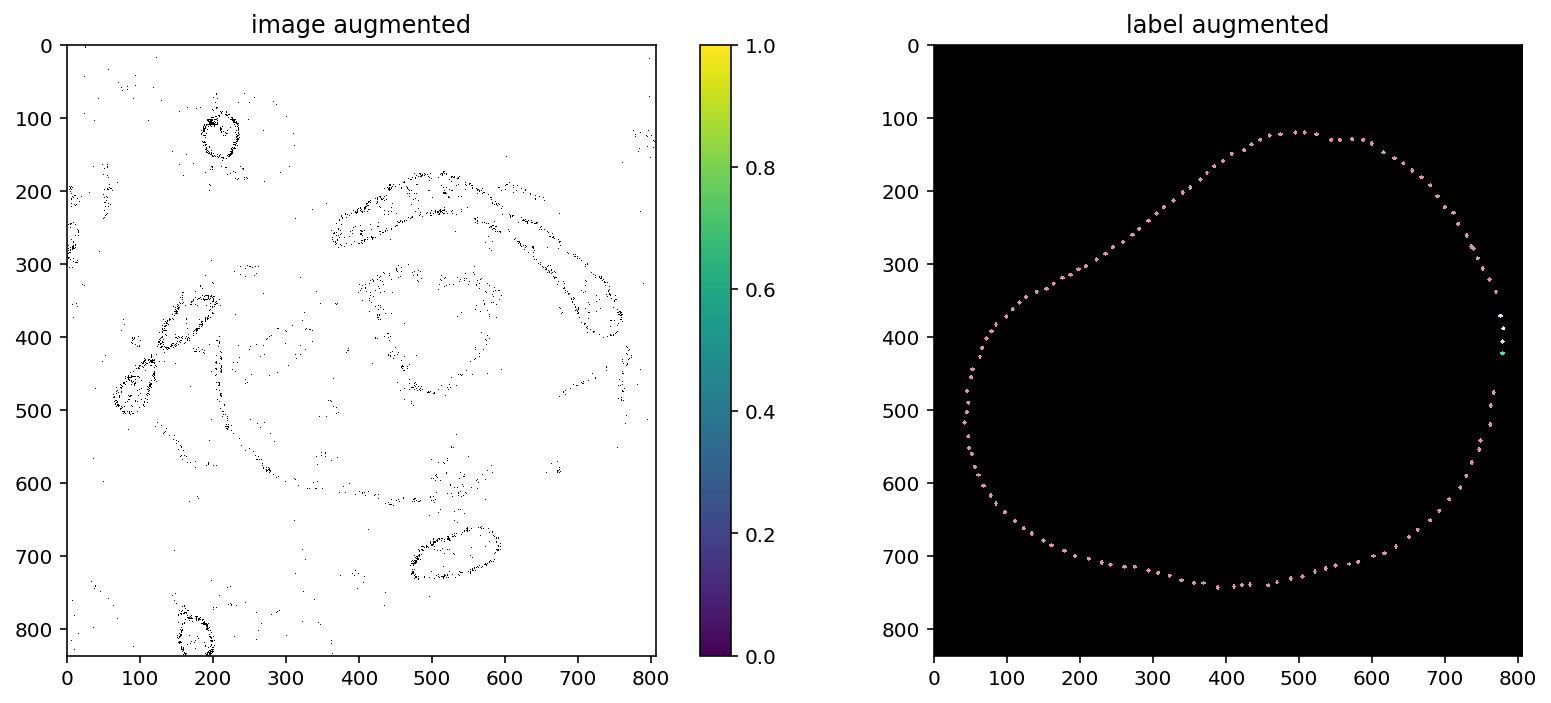

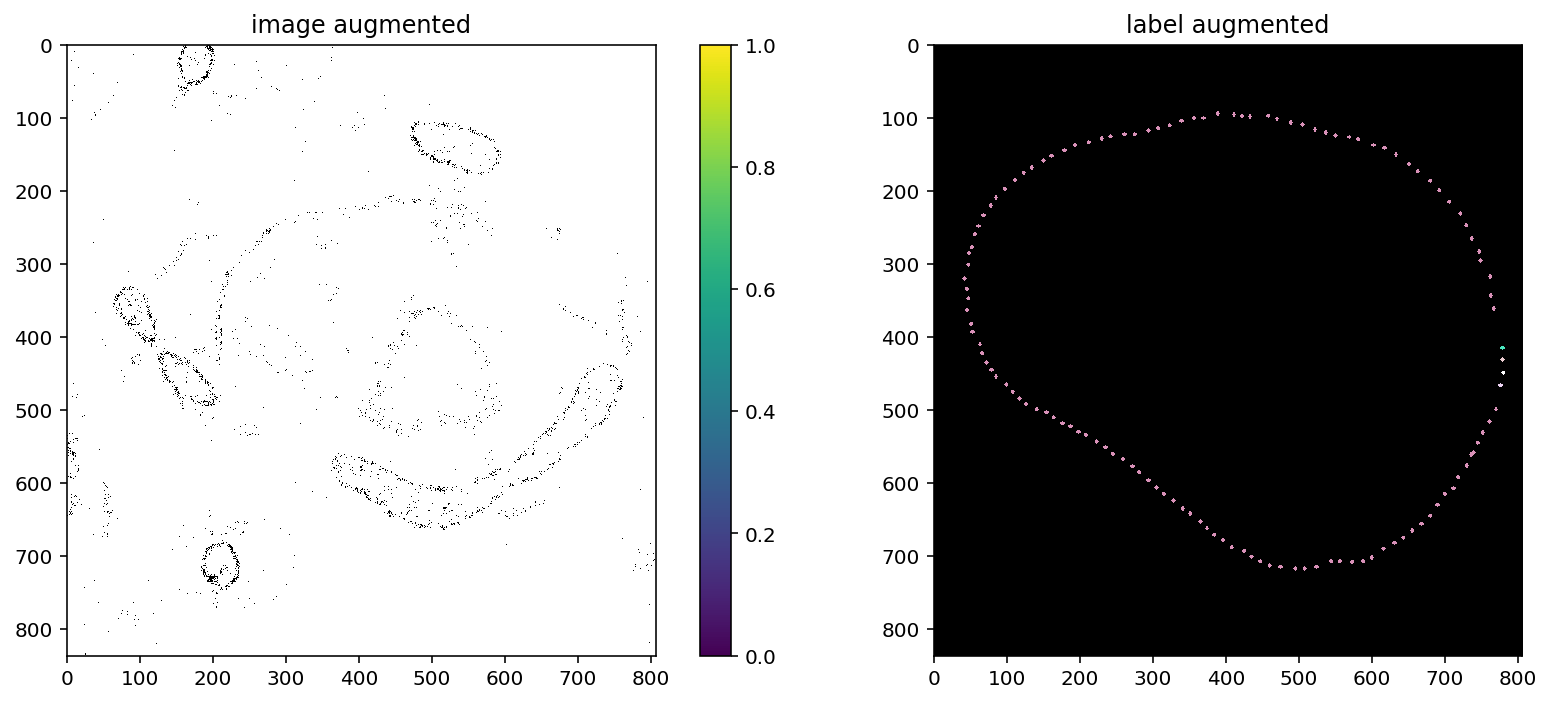

In [28]:
# plot some augmented examples
img, lbl = X[10],Y[10]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

Hmmm... not quite what we expected. There doesn't appear to be an image when it gets augmented? Continue with the rest of the notebook for now though.

Oh, it might be that the intensity change always makes the images white as this time there was a faint image. That seems a bit weird to be honest but let's see.

We are running into a `Graph execution error` which may have to do with the sizing of the images... https://stackoverflow.com/questions/71153492/invalid-argument-error-graph-execution-error

Will have to debug this later, as well as why the image disappears when we do augmentation.

In [36]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), epochs=400)
None;

Epoch 1/400
100/100 [==============================] - 5s 50ms/step - loss: 0.2600 - prob_loss: 0.0210 - dist_loss: 1.1951 - prob_kld: 0.0185 - dist_relevant_mae: 1.1948 - dist_relevant_mse: 2.0300 - dist_dist_iou_metric: 0.4157 - val_loss: 0.2624 - val_prob_loss: 0.0212 - val_dist_loss: 1.2060 - val_prob_kld: 0.0187 - val_dist_relevant_mae: 1.2057 - val_dist_relevant_mse: 2.0378 - val_dist_dist_iou_metric: 0.4099 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 5s 46ms/step - loss: 0.2602 - prob_loss: 0.0204 - dist_loss: 1.1988 - prob_kld: 0.0180 - dist_relevant_mae: 1.1986 - dist_relevant_mse: 2.0455 - dist_dist_iou_metric: 0.4138 - val_loss: 0.2637 - val_prob_loss: 0.0226 - val_dist_loss: 1.2056 - val_prob_kld: 0.0201 - val_dist_relevant_mae: 1.2054 - val_dist_relevant_mse: 2.0317 - val_dist_dist_iou_metric: 0.4036 - lr: 3.0000e-04
Epoch 3/400
100/100 [==============================] - 5s 45ms/step - loss: 0.2581 - prob_loss: 0.0195 - dist_loss: 1.1930 - prob_

Epoch 20/400
100/100 [==============================] - 4s 43ms/step - loss: 0.2458 - prob_loss: 0.0179 - dist_loss: 1.1396 - prob_kld: 0.0154 - dist_relevant_mae: 1.1393 - dist_relevant_mse: 1.9236 - dist_dist_iou_metric: 0.4153 - val_loss: 0.2698 - val_prob_loss: 0.0242 - val_dist_loss: 1.2282 - val_prob_kld: 0.0217 - val_dist_relevant_mae: 1.2279 - val_dist_relevant_mse: 2.1901 - val_dist_dist_iou_metric: 0.4072 - lr: 3.0000e-04
Epoch 21/400
100/100 [==============================] - 4s 44ms/step - loss: 0.2461 - prob_loss: 0.0175 - dist_loss: 1.1430 - prob_kld: 0.0151 - dist_relevant_mae: 1.1427 - dist_relevant_mse: 1.9358 - dist_dist_iou_metric: 0.4139 - val_loss: 0.2728 - val_prob_loss: 0.0236 - val_dist_loss: 1.2456 - val_prob_kld: 0.0211 - val_dist_relevant_mae: 1.2454 - val_dist_relevant_mse: 2.2976 - val_dist_dist_iou_metric: 0.4025 - lr: 3.0000e-04
Epoch 22/400
100/100 [==============================] - 4s 44ms/step - loss: 0.2431 - prob_loss: 0.0177 - dist_loss: 1.1268 - pr

Epoch 39/400
100/100 [==============================] - 4s 43ms/step - loss: 0.2161 - prob_loss: 0.0155 - dist_loss: 1.0030 - prob_kld: 0.0129 - dist_relevant_mae: 1.0028 - dist_relevant_mse: 1.6107 - dist_dist_iou_metric: 0.4837 - val_loss: 0.2818 - val_prob_loss: 0.0275 - val_dist_loss: 1.2715 - val_prob_kld: 0.0248 - val_dist_relevant_mae: 1.2713 - val_dist_relevant_mse: 2.4612 - val_dist_dist_iou_metric: 0.3993 - lr: 3.0000e-04
Epoch 40/400
100/100 [==============================] - 4s 43ms/step - loss: 0.2133 - prob_loss: 0.0157 - dist_loss: 0.9880 - prob_kld: 0.0131 - dist_relevant_mae: 0.9878 - dist_relevant_mse: 1.5676 - dist_dist_iou_metric: 0.4902 - val_loss: 0.2766 - val_prob_loss: 0.0275 - val_dist_loss: 1.2458 - val_prob_kld: 0.0248 - val_dist_relevant_mae: 1.2456 - val_dist_relevant_mse: 2.3749 - val_dist_dist_iou_metric: 0.3939 - lr: 3.0000e-04
Epoch 41/400
100/100 [==============================] - 4s 44ms/step - loss: 0.2116 - prob_loss: 0.0155 - dist_loss: 0.9807 - pr

Epoch 76/400
100/100 [==============================] - 5s 45ms/step - loss: 0.1481 - prob_loss: 0.0116 - dist_loss: 0.6826 - prob_kld: 0.0090 - dist_relevant_mae: 0.6823 - dist_relevant_mse: 0.8870 - dist_dist_iou_metric: 0.6363 - val_loss: 0.2910 - val_prob_loss: 0.0305 - val_dist_loss: 1.3025 - val_prob_kld: 0.0268 - val_dist_relevant_mae: 1.3022 - val_dist_relevant_mse: 2.6600 - val_dist_dist_iou_metric: 0.3911 - lr: 1.5000e-04
Epoch 77/400
100/100 [==============================] - 4s 44ms/step - loss: 0.1477 - prob_loss: 0.0110 - dist_loss: 0.6838 - prob_kld: 0.0085 - dist_relevant_mae: 0.6836 - dist_relevant_mse: 0.8990 - dist_dist_iou_metric: 0.6350 - val_loss: 0.2903 - val_prob_loss: 0.0292 - val_dist_loss: 1.3057 - val_prob_kld: 0.0262 - val_dist_relevant_mae: 1.3055 - val_dist_relevant_mse: 2.6939 - val_dist_dist_iou_metric: 0.3976 - lr: 1.5000e-04
Epoch 78/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1464 - prob_loss: 0.0109 - dist_loss: 0.6773 - pr

Epoch 113/400
100/100 [==============================] - 4s 44ms/step - loss: 0.1223 - prob_loss: 0.0099 - dist_loss: 0.5618 - prob_kld: 0.0074 - dist_relevant_mae: 0.5616 - dist_relevant_mse: 0.6723 - dist_dist_iou_metric: 0.6950 - val_loss: 0.3078 - val_prob_loss: 0.0324 - val_dist_loss: 1.3769 - val_prob_kld: 0.0284 - val_dist_relevant_mae: 1.3767 - val_dist_relevant_mse: 3.0173 - val_dist_dist_iou_metric: 0.3759 - lr: 7.5000e-05
Epoch 114/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1199 - prob_loss: 0.0096 - dist_loss: 0.5512 - prob_kld: 0.0071 - dist_relevant_mae: 0.5510 - dist_relevant_mse: 0.6528 - dist_dist_iou_metric: 0.6996 - val_loss: 0.3038 - val_prob_loss: 0.0326 - val_dist_loss: 1.3562 - val_prob_kld: 0.0286 - val_dist_relevant_mae: 1.3560 - val_dist_relevant_mse: 2.9268 - val_dist_dist_iou_metric: 0.3759 - lr: 7.5000e-05
Epoch 115/400
100/100 [==============================] - 4s 44ms/step - loss: 0.1240 - prob_loss: 0.0101 - dist_loss: 0.5695 -

Epoch 132/400
100/100 [==============================] - ETA: 0s - loss: 0.1134 - prob_loss: 0.0091 - dist_loss: 0.5214 - prob_kld: 0.0067 - dist_relevant_mae: 0.5212 - dist_relevant_mse: 0.5984 - dist_dist_iou_metric: 0.7143
Epoch 00132: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
100/100 [==============================] - 4s 44ms/step - loss: 0.1134 - prob_loss: 0.0091 - dist_loss: 0.5214 - prob_kld: 0.0067 - dist_relevant_mae: 0.5212 - dist_relevant_mse: 0.5984 - dist_dist_iou_metric: 0.7143 - val_loss: 0.3083 - val_prob_loss: 0.0333 - val_dist_loss: 1.3753 - val_prob_kld: 0.0292 - val_dist_relevant_mae: 1.3751 - val_dist_relevant_mse: 3.0288 - val_dist_dist_iou_metric: 0.3789 - lr: 7.5000e-05
Epoch 133/400
100/100 [==============================] - 4s 44ms/step - loss: 0.1130 - prob_loss: 0.0095 - dist_loss: 0.5177 - prob_kld: 0.0069 - dist_relevant_mae: 0.5175 - dist_relevant_mse: 0.5964 - dist_dist_iou_metric: 0.7169 - val_loss: 0.3116 - val_prob_loss: 0.0

Epoch 169/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1054 - prob_loss: 0.0088 - dist_loss: 0.4831 - prob_kld: 0.0063 - dist_relevant_mae: 0.4829 - dist_relevant_mse: 0.5466 - dist_dist_iou_metric: 0.7340 - val_loss: 0.3165 - val_prob_loss: 0.0349 - val_dist_loss: 1.4080 - val_prob_kld: 0.0299 - val_dist_relevant_mae: 1.4078 - val_dist_relevant_mse: 3.1703 - val_dist_dist_iou_metric: 0.3602 - lr: 3.7500e-05
Epoch 170/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1010 - prob_loss: 0.0081 - dist_loss: 0.4643 - prob_kld: 0.0057 - dist_relevant_mae: 0.4641 - dist_relevant_mse: 0.5083 - dist_dist_iou_metric: 0.7435 - val_loss: 0.3179 - val_prob_loss: 0.0358 - val_dist_loss: 1.4106 - val_prob_kld: 0.0306 - val_dist_relevant_mae: 1.4104 - val_dist_relevant_mse: 3.1720 - val_dist_dist_iou_metric: 0.3577 - lr: 3.7500e-05
Epoch 171/400
100/100 [==============================] - 4s 44ms/step - loss: 0.1007 - prob_loss: 0.0086 - dist_loss: 0.4604 -

Epoch 206/400
100/100 [==============================] - 4s 43ms/step - loss: 0.0997 - prob_loss: 0.0087 - dist_loss: 0.4552 - prob_kld: 0.0061 - dist_relevant_mae: 0.4550 - dist_relevant_mse: 0.5085 - dist_dist_iou_metric: 0.7480 - val_loss: 0.3239 - val_prob_loss: 0.0365 - val_dist_loss: 1.4371 - val_prob_kld: 0.0309 - val_dist_relevant_mae: 1.4370 - val_dist_relevant_mse: 3.3026 - val_dist_dist_iou_metric: 0.3511 - lr: 1.8750e-05
Epoch 207/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1027 - prob_loss: 0.0087 - dist_loss: 0.4698 - prob_kld: 0.0062 - dist_relevant_mae: 0.4696 - dist_relevant_mse: 0.5310 - dist_dist_iou_metric: 0.7415 - val_loss: 0.3252 - val_prob_loss: 0.0362 - val_dist_loss: 1.4447 - val_prob_kld: 0.0309 - val_dist_relevant_mae: 1.4445 - val_dist_relevant_mse: 3.3174 - val_dist_dist_iou_metric: 0.3484 - lr: 1.8750e-05
Epoch 208/400
100/100 [==============================] - 4s 43ms/step - loss: 0.1003 - prob_loss: 0.0086 - dist_loss: 0.4585 -

Epoch 243/400
100/100 [==============================] - 5s 48ms/step - loss: 0.0994 - prob_loss: 0.0084 - dist_loss: 0.4550 - prob_kld: 0.0059 - dist_relevant_mae: 0.4548 - dist_relevant_mse: 0.5040 - dist_dist_iou_metric: 0.7484 - val_loss: 0.3286 - val_prob_loss: 0.0366 - val_dist_loss: 1.4601 - val_prob_kld: 0.0308 - val_dist_relevant_mae: 1.4599 - val_dist_relevant_mse: 3.3924 - val_dist_dist_iou_metric: 0.3448 - lr: 9.3750e-06
Epoch 244/400
100/100 [==============================] - 5s 46ms/step - loss: 0.0960 - prob_loss: 0.0082 - dist_loss: 0.4389 - prob_kld: 0.0058 - dist_relevant_mae: 0.4387 - dist_relevant_mse: 0.4740 - dist_dist_iou_metric: 0.7552 - val_loss: 0.3270 - val_prob_loss: 0.0365 - val_dist_loss: 1.4530 - val_prob_kld: 0.0307 - val_dist_relevant_mae: 1.4528 - val_dist_relevant_mse: 3.3704 - val_dist_dist_iou_metric: 0.3478 - lr: 9.3750e-06
Epoch 245/400
100/100 [==============================] - 5s 46ms/step - loss: 0.0989 - prob_loss: 0.0083 - dist_loss: 0.4530 -

100/100 [==============================] - 5s 46ms/step - loss: 0.0953 - prob_loss: 0.0080 - dist_loss: 0.4367 - prob_kld: 0.0055 - dist_relevant_mae: 0.4365 - dist_relevant_mse: 0.4718 - dist_dist_iou_metric: 0.7570 - val_loss: 0.3289 - val_prob_loss: 0.0371 - val_dist_loss: 1.4589 - val_prob_kld: 0.0312 - val_dist_relevant_mae: 1.4588 - val_dist_relevant_mse: 3.3875 - val_dist_dist_iou_metric: 0.3456 - lr: 4.6875e-06
Epoch 280/400
100/100 [==============================] - 5s 46ms/step - loss: 0.0954 - prob_loss: 0.0082 - dist_loss: 0.4364 - prob_kld: 0.0056 - dist_relevant_mae: 0.4362 - dist_relevant_mse: 0.4758 - dist_dist_iou_metric: 0.7573 - val_loss: 0.3309 - val_prob_loss: 0.0374 - val_dist_loss: 1.4673 - val_prob_kld: 0.0314 - val_dist_relevant_mae: 1.4671 - val_dist_relevant_mse: 3.4204 - val_dist_dist_iou_metric: 0.3424 - lr: 4.6875e-06
Epoch 281/400
100/100 [==============================] - 5s 47ms/step - loss: 0.0943 - prob_loss: 0.0083 - dist_loss: 0.4302 - prob_kld: 0.0

100/100 [==============================] - 5s 49ms/step - loss: 0.0944 - prob_loss: 0.0079 - dist_loss: 0.4328 - prob_kld: 0.0054 - dist_relevant_mae: 0.4326 - dist_relevant_mse: 0.4692 - dist_dist_iou_metric: 0.7593 - val_loss: 0.3297 - val_prob_loss: 0.0369 - val_dist_loss: 1.4642 - val_prob_kld: 0.0311 - val_dist_relevant_mae: 1.4640 - val_dist_relevant_mse: 3.4085 - val_dist_dist_iou_metric: 0.3437 - lr: 2.3438e-06
Epoch 316/400
100/100 [==============================] - 5s 49ms/step - loss: 0.0954 - prob_loss: 0.0082 - dist_loss: 0.4361 - prob_kld: 0.0057 - dist_relevant_mae: 0.4359 - dist_relevant_mse: 0.4711 - dist_dist_iou_metric: 0.7578 - val_loss: 0.3299 - val_prob_loss: 0.0369 - val_dist_loss: 1.4649 - val_prob_kld: 0.0312 - val_dist_relevant_mae: 1.4648 - val_dist_relevant_mse: 3.4106 - val_dist_dist_iou_metric: 0.3435 - lr: 2.3438e-06
Epoch 317/400
100/100 [==============================] - 5s 47ms/step - loss: 0.0912 - prob_loss: 0.0082 - dist_loss: 0.4151 - prob_kld: 0.0

Epoch 352/400
100/100 [==============================] - 5s 46ms/step - loss: 0.0965 - prob_loss: 0.0085 - dist_loss: 0.4400 - prob_kld: 0.0059 - dist_relevant_mae: 0.4398 - dist_relevant_mse: 0.4913 - dist_dist_iou_metric: 0.7560 - val_loss: 0.3309 - val_prob_loss: 0.0371 - val_dist_loss: 1.4692 - val_prob_kld: 0.0312 - val_dist_relevant_mae: 1.4690 - val_dist_relevant_mse: 3.4373 - val_dist_dist_iou_metric: 0.3433 - lr: 1.1719e-06
Epoch 353/400
100/100 [==============================] - 5s 48ms/step - loss: 0.0936 - prob_loss: 0.0083 - dist_loss: 0.4268 - prob_kld: 0.0057 - dist_relevant_mae: 0.4266 - dist_relevant_mse: 0.4606 - dist_dist_iou_metric: 0.7623 - val_loss: 0.3306 - val_prob_loss: 0.0370 - val_dist_loss: 1.4680 - val_prob_kld: 0.0312 - val_dist_relevant_mae: 1.4678 - val_dist_relevant_mse: 3.4319 - val_dist_dist_iou_metric: 0.3434 - lr: 1.1719e-06
Epoch 354/400
100/100 [==============================] - 5s 47ms/step - loss: 0.0995 - prob_loss: 0.0086 - dist_loss: 0.4545 -

Epoch 371/400
100/100 [==============================] - 5s 46ms/step - loss: 0.0931 - prob_loss: 0.0081 - dist_loss: 0.4248 - prob_kld: 0.0056 - dist_relevant_mae: 0.4246 - dist_relevant_mse: 0.4594 - dist_dist_iou_metric: 0.7631 - val_loss: 0.3305 - val_prob_loss: 0.0370 - val_dist_loss: 1.4678 - val_prob_kld: 0.0311 - val_dist_relevant_mae: 1.4676 - val_dist_relevant_mse: 3.4308 - val_dist_dist_iou_metric: 0.3438 - lr: 1.1719e-06
Epoch 372/400
 99/100 [============================>.] - ETA: 0s - loss: 0.0948 - prob_loss: 0.0084 - dist_loss: 0.4317 - prob_kld: 0.0058 - dist_relevant_mae: 0.4316 - dist_relevant_mse: 0.4646 - dist_dist_iou_metric: 0.7603
Epoch 00372: ReduceLROnPlateau reducing learning rate to 5.859375278305379e-07.
100/100 [==============================] - 5s 47ms/step - loss: 0.0947 - prob_loss: 0.0084 - dist_loss: 0.4314 - prob_kld: 0.0058 - dist_relevant_mae: 0.4313 - dist_relevant_mse: 0.4640 - dist_dist_iou_metric: 0.7604 - val_loss: 0.3311 - val_prob_loss: 0.03

In [37]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:02<00:00,  5.53it/s, 0.080 -> 0.000]


Using optimized values: prob_thresh=0.0801321, nms_thresh=0.3.
Saving to 'thresholds.json'.


In [48]:
model.summary()

AttributeError: 'StarDist2D' object has no attribute 'summary'

In [38]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


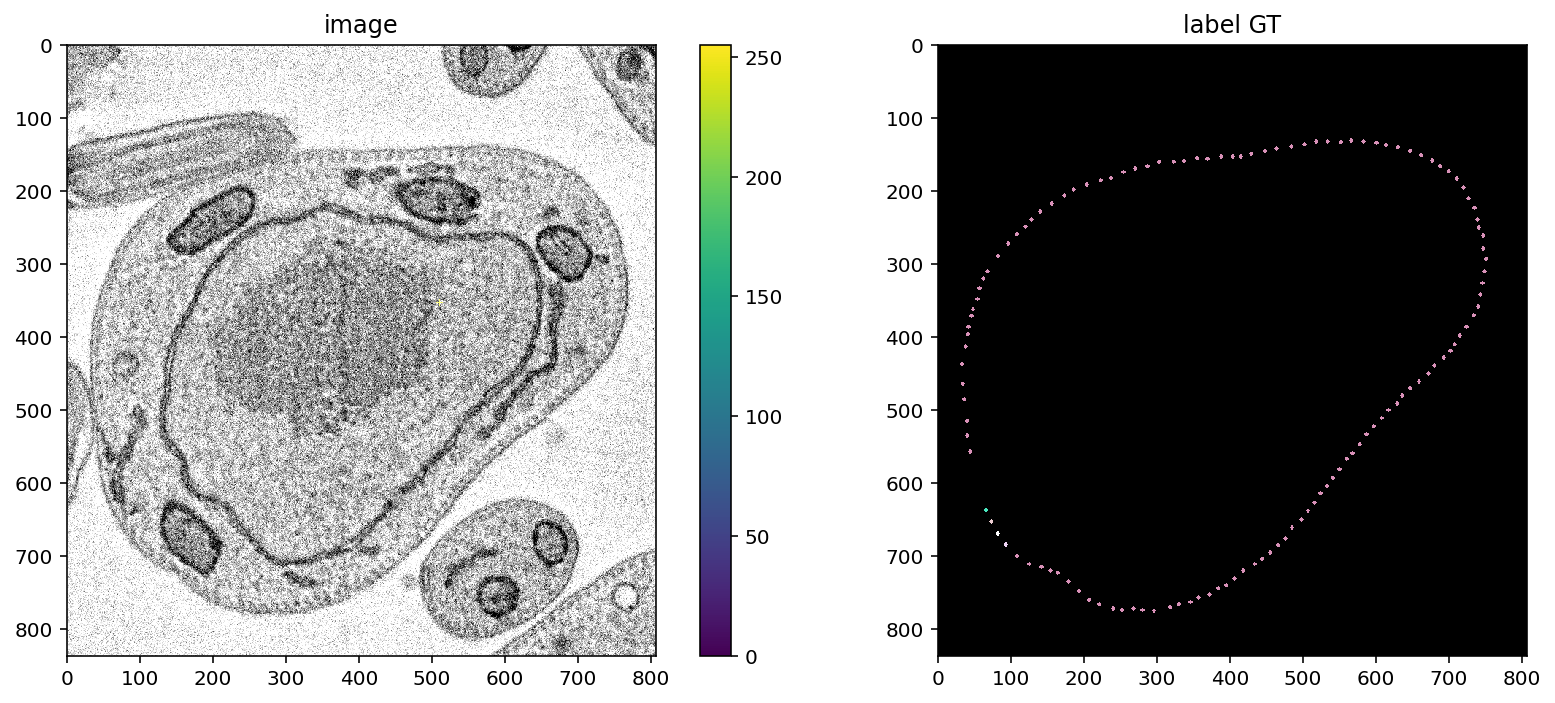

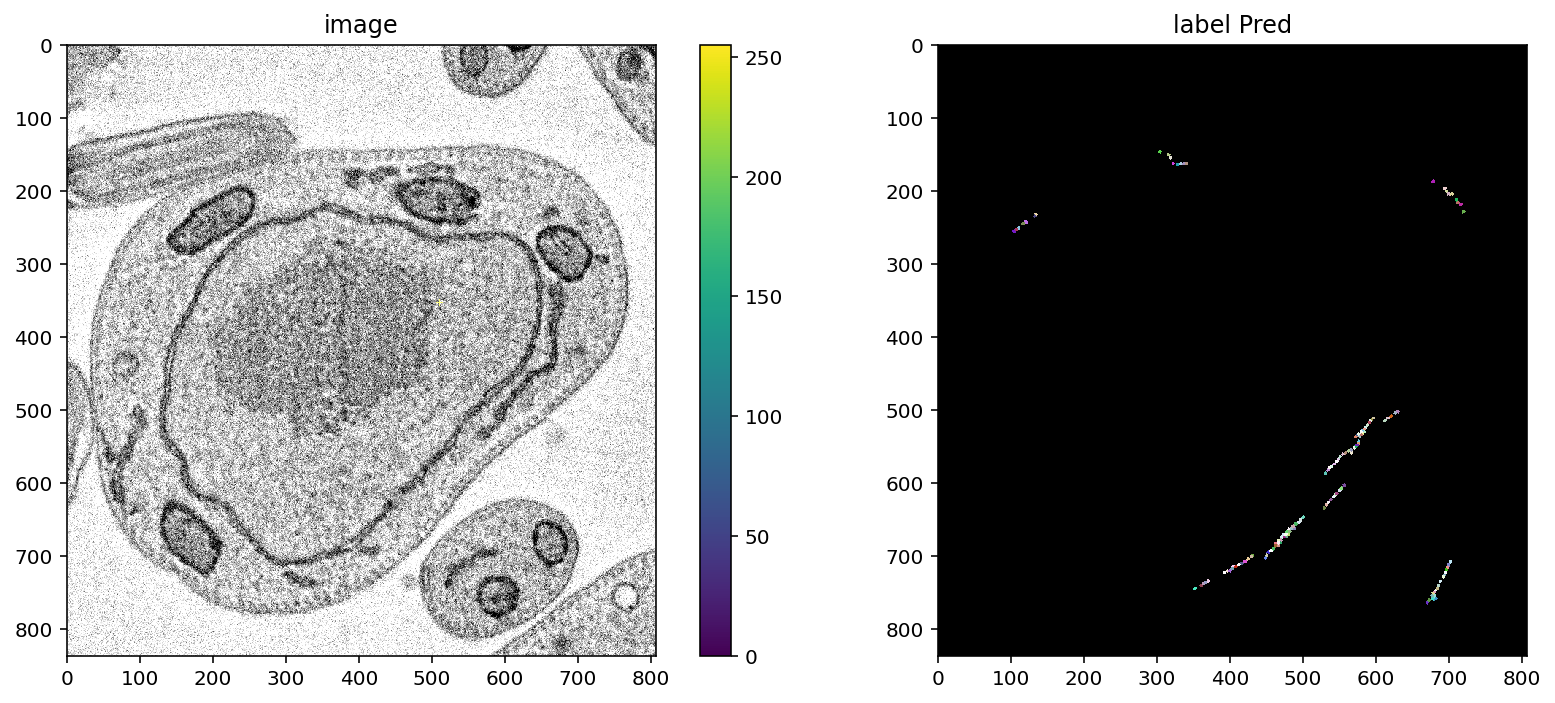

In [39]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

In [40]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  7.60it/s]


In [42]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=1021, tp=0, fn=30, precision=0, recall=0, accuracy=0, f1=0, n_true=30, n_pred=1021, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

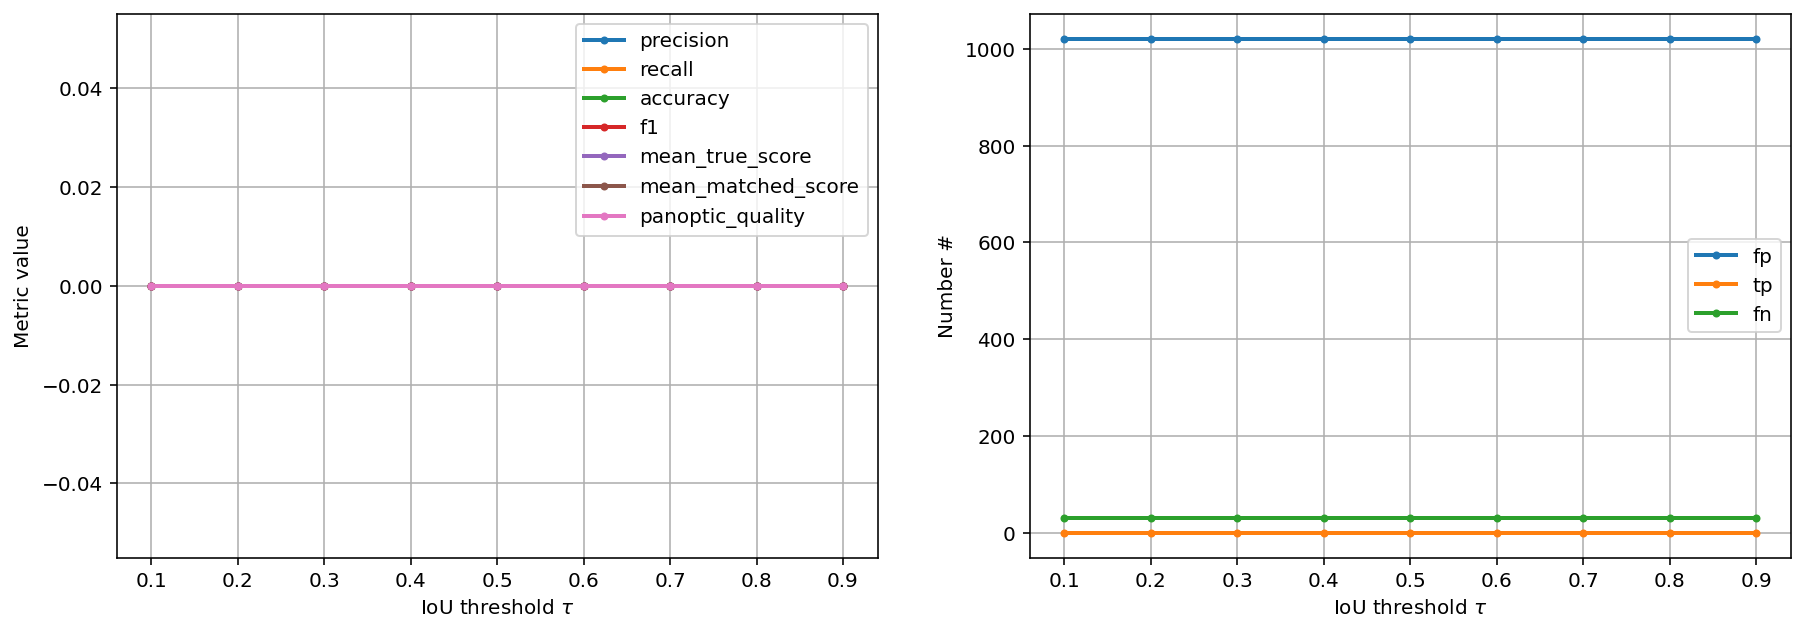

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

# Pretrained models

We tried a pretrained model, however it does not work at all, which is to be expected since it is for cell identification.

In [ ]:
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

StarDist2D.from_pretrained()

In [ ]:
img = X[5]
labels, _ = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

## Log

### 3/17/23

 * Tested default model training with 20 epochs and 400 epochs. Appears that 20 epochs is too short but does capture shape, and 400 epochs is too long and model is overfitted.